# EDR Signatures
Author: Louis Richard\
A routine to compute various parameters used to identify electron diffusion regions for the four MMS spacecraft. 

Quantities calculated so far are:
- sqrt(Q) : Based on Swisdak, GRL ,2016. Values around 0.1 indicate electron agyrotropies. Computed based on the off-diagonal terms in the pressure tensor for Pe_perp1 = Pe_perp2.

- Dng: Based on Aunai et al., 2013; Computed based on the off-diagonal terms in the pressure tensor for Pe_perp1 = Pe_perp2. Similar to sqrt(Q) but with different normalization. Calculated but not plotted. 

- AG^(1/3): Based on Che et al., POP, 2018. Constructed from determinant of field-aligned rotation of the electron pressure tensor (Pe_perp1 = Pe_perp2). 

- A phi_e/2 = abs(Perp1-Perp2)/(Perp1+Perp2): This is a measure of electron agyrotropy. Values of O(1) are expected for EDRs. We transform the pressure tensor into field-aligned coordinates such that the difference in Pe_perp1 and Pe_perp2 is maximal. This corresponds to P23 being zero. (Note that this definition of agyrotropy neglects the off-diagonal pressure terms P12 and P13, therefore it doesn't capture all agyrotropies.)

- A n_e = T_parallel/T_perp: Values much larger than 1 are expected. Large T_parallel/T_perp are a feature of the ion diffusion region. For MP reconnection ion diffusion regions have A n_e ~ 3 based on MMS observations. Scudder says A n_e ~ 7 at IDR-EDR boundary, but this is extremely large for MP reconnection.

- Mperp e: electron Mach number: bulk velocity divided by the electron thermal speed perpendicular to B. Values of O(1) are expected in EDRs (Scudder et al., 2012, 2015). 

- J.E': J.E > 0 is expected in the electron diffusion region, corresponding to dissipation of field energy. J is calculated on each spacecraft using the particle moments (Zenitani et al., 2011, PRL). 

- epsilon_e: Energy gain per cyclotron period. Values of O(1) are expected in EDRs (Scudder et al., 2012, 2015). 
- delta_e: Relative strength of the electric and magnetic force in the bulk electron rest frame. N. B. Very sensitive to electron moments and electric field. Check version of these quantities (Scudder et al., 2012, 2015). 
    
Notes: 
kappa_e (not yet included) is taken to be the largest value of epsilon_e and delta_e at any given point. Requires electron distributions with version number v2.0.0 or higher. Calculations of agyrotropy measures (1)--(3) become unreliable at low densities n_e <~ 2 cm^-3, when the raw particle counts are low. Agyrotropies are removed for n_e < 1 cm^-3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from pyrfu import mms, pyrf
from pyrfu.plot import make_labels, pl_tx
from scipy import constants

Load IGRF coefficients ...


## Time interval selection and data path

In [2]:
tint = ["2015-12-14T01:17:38.000", "2015-12-14T01:17:41.000"]
mms.db_init("/Volumes/mms")

## Load Data

### Load fields

In [3]:
b_mms = [mms.get_data("b_dmpa_fgm_srvy_l2", tint, i) for i in range(1, 5)]
e_mms = [mms.get_data("e_dsl_edp_brst_l2", tint, i) for i in range(1, 5)]

[07-Jun-23 16:17:04] INFO: Loading mms1_fgm_b_dmpa_srvy_l2...
[07-Jun-23 16:17:04] INFO: Loading mms2_fgm_b_dmpa_srvy_l2...
[07-Jun-23 16:17:05] INFO: Loading mms3_fgm_b_dmpa_srvy_l2...
[07-Jun-23 16:17:05] INFO: Loading mms4_fgm_b_dmpa_srvy_l2...
[07-Jun-23 16:17:06] INFO: Loading mms1_edp_dce_dsl_brst_l2...
[07-Jun-23 16:17:06] INFO: Loading mms2_edp_dce_dsl_brst_l2...
[07-Jun-23 16:17:06] INFO: Loading mms3_edp_dce_dsl_brst_l2...
[07-Jun-23 16:17:07] INFO: Loading mms4_edp_dce_dsl_brst_l2...


### Load particles moments

In [4]:
n_mms_e = [mms.get_data("ne_fpi_brst_l2", tint, i) for i in range(1, 5)]
v_mms_e = [mms.get_data("ve_dbcs_fpi_brst_l2", tint, i) for i in range(1, 5)]
v_mms_i = [mms.get_data("vi_dbcs_fpi_brst_l2", tint, i) for i in range(1, 5)]
t_mms_e = [mms.get_data("te_dbcs_fpi_brst_l2", tint, i) for i in range(1, 5)]
p_mms_e = [mms.get_data("pe_dbcs_fpi_brst_l2", tint, i) for i in range(1, 5)]

[07-Jun-23 16:17:07] INFO: Loading mms1_des_numberdensity_brst...
[07-Jun-23 16:17:07] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[07-Jun-23 16:17:07] INFO: Loading mms2_des_numberdensity_brst...
[07-Jun-23 16:17:07] INFO: Loading mms3_des_numberdensity_brst...
[07-Jun-23 16:17:07] INFO: Loading mms4_des_numberdensity_brst...
[07-Jun-23 16:17:07] INFO: Loading mms1_des_bulkv_dbcs_brst...
[07-Jun-23 16:17:07] INFO: Loading mms2_des_bulkv_dbcs_brst...
[07-Jun-23 16:17:07] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[07-Jun-23 16:17:07] INFO: Loading mms3_des_bulkv_dbcs_brst...
[07-Jun-23 16:17:07] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, 

### Resample to DES sampling frequency

In [5]:
e_mms = [pyrf.resample(e_xyz, n_e) for e_xyz, n_e in zip(e_mms, n_mms_e)]
b_mms = [pyrf.resample(b_xyz, n_e) for b_xyz, n_e in zip(b_mms, n_mms_e)]
v_mms_i = [pyrf.resample(v_xyz_i, n_e) for v_xyz_i, n_e in zip(v_mms_i, n_mms_e)]

[07-Jun-23 16:17:08] INFO: Using averages in resample
[07-Jun-23 16:17:08] INFO: Using averages in resample
[07-Jun-23 16:17:08] INFO: Using averages in resample
[07-Jun-23 16:17:08] INFO: Using averages in resample


## Rotate pressure and temperature tensors

In [6]:
p_mms_e_pp = [
    mms.rotate_tensor(p_xyz, "fac", b_xyz, "pp") for p_xyz, b_xyz in zip(p_mms_e, b_mms)
]
p_mms_e_qq = [
    mms.rotate_tensor(p_xyz, "fac", b_xyz, "qq") for p_xyz, b_xyz in zip(p_mms_e, b_mms)
]
t_mms_e_fac = [
    mms.rotate_tensor(t_xyz, "fac", b_xyz) for t_xyz, b_xyz in zip(t_mms_e, b_mms)
]

## Compute tests for EDR

### Compute Q and Dng from Pepp

In [7]:
sqrtq_mms = [pyrf.calc_sqrtq(p_pp) for p_pp in p_mms_e_pp]
dng_mms = [pyrf.calc_dng(p_pp) for p_pp in p_mms_e_pp]

### Compute agyrotropy measure AG1/3

In [8]:
ag_mms = [pyrf.calc_ag(p_pp) for p_pp in p_mms_e_pp]
ag_cr_mms = [ag ** (1 / 3) for ag in ag_mms]

### Compute agyrotropy Aphi from Peqq

In [9]:
agyro_mms = [pyrf.calc_agyro(p_qq) for p_qq in p_mms_e_qq]

### Simple fix to remove spurious points

In [10]:
for sqrtq, dng, agyro, ag_cr in zip(sqrtq_mms, dng_mms, agyro_mms, ag_cr_mms):
    for coeff in [sqrtq, dng, agyro, ag_cr]:
        coeff_data = coeff.data.copy()
        for ii in range(len(coeff_data) - 1):
            if coeff[ii] > 2 * coeff[ii - 1] and coeff[ii] > 2 * coeff[ii + 1]:
                coeff_data[ii] = np.nan

        coeff.data = coeff_data

### Remove all points corresponding to densities below 1cm^-3

In [11]:
for n_e, sqrtq, dng, agyro, ag_cr in zip(
    n_mms_e, sqrtq_mms, dng_mms, agyro_mms, ag_cr_mms
):
    sqrtq.data[n_e.data < 1] = np.nan
    dng.data[n_e.data < 1] = np.nan
    agyro.data[n_e.data < 1] = np.nan
    ag_cr.data[n_e.data < 1] = np.nan

### Compute temperature ratio An

In [12]:
t_rat_mms = [p_pp[:, 0, 0] / p_pp[:, 1, 1] for p_pp in p_mms_e_pp]

### Compute electron Mach number

In [13]:
qe, me = [constants.elementary_charge, constants.electron_mass]
v_mms_e_mag = [pyrf.norm(v_xyz_e) for v_xyz_e in v_mms_e]
v_mms_e_per = [
    np.sqrt((t_fac_e[:, 1, 1] + t_fac_e[:, 2, 2]) * qe / me) for t_fac_e in t_mms_e_fac
]
m_mms_e = [
    1e3 * v_e_mag / v_e_perp for v_e_mag, v_e_perp in zip(v_mms_e_mag, v_mms_e_per)
]

### Compute current density and J.E

In [14]:
# Current density in nA m^-2
j_mms_moms = [
    1e18 * qe * n_e * (v_xyz_i - v_xyz_e)
    for n_e, v_xyz_i, v_xyz_e in zip(n_mms_e, v_mms_i, v_mms_e)
]
vexb_mms = [
    e_xyz + 1e-3 * pyrf.cross(v_xyz_e, b_xyz)
    for e_xyz, v_xyz_e, b_xyz in zip(e_mms, v_mms_e, b_mms)
]
# J (nA/m^2), E (mV/m), E.J (nW/m^3)
edotj_mms = [
    1e-3 * pyrf.dot(vexb_xyz, j_xyz) for vexb_xyz, j_xyz in zip(vexb_mms, j_mms_moms)
]

### Calculate epsilon and delta parameters

In [15]:
w_mms_ce = [1e-9 * qe * pyrf.norm(b_xyz) / me for b_xyz in b_mms]
edotve_mms = [pyrf.dot(e_xyz, v_xyz_e) for e_xyz, v_xyz_e in zip(e_mms, v_mms_e)]
eps_mms_e = [
    np.abs(6 * np.pi * edotve_xyz / (w_ce * pyrf.trace(t_fac_e)))
    for edotve_xyz, w_ce, t_fac_e in zip(edotve_mms, w_mms_ce, t_mms_e_fac)
]
delta_mms_e = [
    1e-3 * pyrf.norm(vexb_xyz) / (v_xyz_e_per * pyrf.norm(b_xyz) * 1e-9)
    for vexb_xyz, v_xyz_e_per, b_xyz in zip(vexb_mms, v_mms_e_per, b_mms)
]

## Plot figure

In [16]:
legend_options = dict(ncol=4, frameon=True, loc="upper right")

[07-Jun-23 16:17:11] INFO: Substituting symbol \perp from STIXGeneral
[07-Jun-23 16:17:11] INFO: Substituting symbol \perp from STIXGeneral
[07-Jun-23 16:17:11] INFO: Substituting symbol \perp from STIXGeneral
[07-Jun-23 16:17:11] INFO: Substituting symbol \perp from STIXGeneral
[07-Jun-23 16:17:13] INFO: Substituting symbol \perp from STIXGeneral
[07-Jun-23 16:17:13] INFO: Substituting symbol \perp from STIXGeneral
[07-Jun-23 16:17:13] INFO: Substituting symbol \perp from STIXGeneral
[07-Jun-23 16:17:13] INFO: Substituting symbol \perp from STIXGeneral


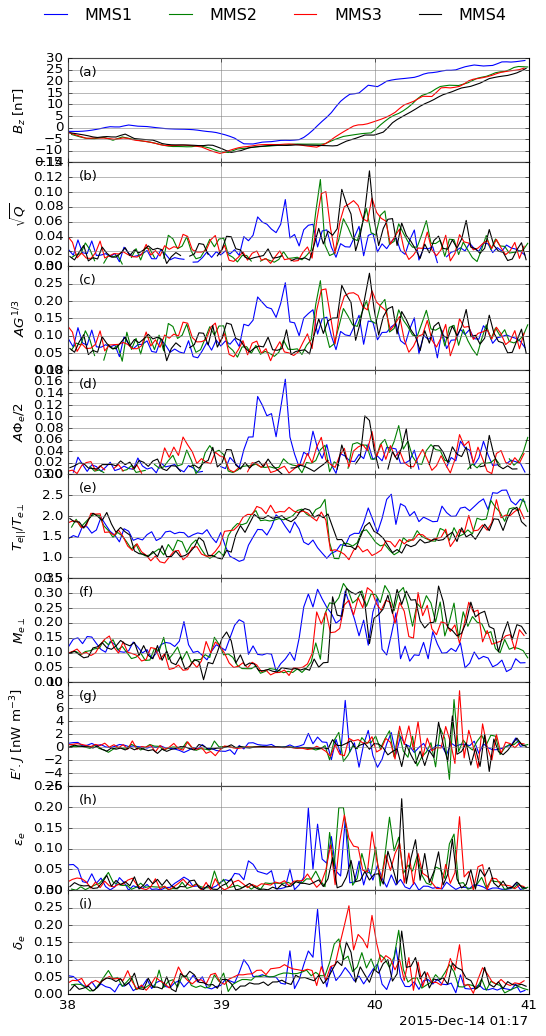

In [17]:
f, axs = plt.subplots(9, sharex="all", figsize=(9, 13))
f.subplots_adjust(hspace=0, left=0.18, right=0.82, bottom=0.05, top=0.95)

pl_tx(axs[0], b_mms, 2)
axs[0].set_ylabel("$B_{z}$ [nT]")
labels = ["MMS{:d}".format(ic) for ic in range(1, 5)]
f.legend(
    labels=labels,
    loc="upper center",
    borderaxespad=0.1,
    ncol=4,
    frameon=False,
)

pl_tx(axs[1], sqrtq_mms, 0)
axs[1].set_ylabel("$\sqrt{Q}$")

pl_tx(axs[2], ag_cr_mms, 0)
axs[2].set_ylabel("$AG^{1/3}$")

pl_tx(axs[3], agyro_mms, 0)
axs[3].set_ylabel("$A\Phi_e / 2$")

pl_tx(axs[4], t_rat_mms, 0)
axs[4].set_ylabel("$T_{e||}/T_{e \perp}$")

pl_tx(axs[5], m_mms_e, 0)
axs[5].set_ylabel("$M_{e \perp}$")

pl_tx(axs[6], edotj_mms, 0)
axs[6].set_ylabel("$E'.J$ [nW m$^{-3}$]")

pl_tx(axs[7], eps_mms_e, 0)
axs[7].set_ylabel("$\epsilon_{e}$")

pl_tx(axs[8], delta_mms_e, 0)
axs[8].set_ylabel("$\delta_{e}$")

make_labels(axs, [0.025, 0.83])


axs[-1].set_xlim(pyrf.iso86012datetime64(np.array(tint)))
f.align_ylabels(axs)